## Bootstrap analysis for Supplementary Figure (Fig. S3)
### Averages subsets of each group (neonate, adult, macaque) and calculates divergence maps
### 100 iterations with replacement

### We provide average maps with this code release (subject maps require data access agreements with relevant data repositories)
### To produce figures, start from cell 17


##### Citation: Warrington*, Thompson*, Bastiani, Dubois, Baxter, Slater, Jbabdi, Mars, Sotiropoulos (bioRxiv), "Concurrent mapping of brain ontogeny and phylogeny within a common space"
##### Corresponding author: Shaun Warrington, shaun.warrington1@nottingham.ac.uk; Stamatios Sotiropoulos, Stamatios.Sotiropoulos@nottingham.ac.uk

In [1]:
import numpy as np
import nibabel as nib
from nibabel import cifti2
from numpy import matlib
import pandas as pd
import scipy
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
from surfplot import Plot

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

### Functions

In [2]:
# save data as CIFTI file
def data_to_cifti(data, fname, roi_left, roi_right=None):
    
    if data.ndim==1:
        data=np.expand_dims(data, axis=0)
    
    n,ctx=data.shape
    
    #set up cifti brain model axes
    bm_ctx_left = cifti2.BrainModelAxis.from_mask(roi_left, name="CortexLeft")
    
    if roi_right is not None:
        bm_ctx_right = cifti2.BrainModelAxis.from_mask(roi_right, name="CortexRight")
        bm = bm_ctx_left + bm_ctx_right 
        
    else :bm = bm_ctx_left
    sc = cifti2.ScalarAxis(np.arange(n).astype("str"))

    #save cifti
    hdr = cifti2.Cifti2Header.from_axes((sc,bm))
    img = cifti2.Cifti2Image(data, hdr)

    nib.save(img, fname)
    
# Remove contralateral tract data
def remove_contra(bp, tracts, n_left):
    tract_names = sorted(list(set([ x.split("_")[0] for x in tracts ])))
    
    bp_new = np.zeros((len(tract_names),bp.shape[1]))

    for i, t in enumerate(tracts):
        new_i = tract_names.index(t.split("_")[0])
        if len(t.split("_")) == 1:
            bp_new[new_i,:] = bp[i,:]
        
        elif t.split("_")[1] == "l":
            bp_new[new_i, :n_left] = bp[i, :n_left]
        
        elif t.split("_")[1] == "r":
            bp_new[new_i, n_left:] = bp[i, n_left:]
    
    #normalise
    #bp_new = bp_new / np.sum(bp_new, axis=0)
    
    return bp_new

# find the tract contribution at a particular vertex
def ctx2cifti(ctx_index, hemi, roi_l, roi_r, bp):
    
    idx = np.append(np.cumsum(roi_l)*roi_l, np.cumsum(roi_r)*roi_r+np.sum(roi_l))
    if hemi=="l":
        cifti_index = idx[ctx_index].astype(int)
    
    elif hemi=="r":
        cifti_index = idx[ctx_index + len(roi_l)].astype(int)

    plt.xticks(rotation=45, size="xx-small")
    plt.plot(tract_names,bp[:,cifti_index],marker=".")
    ax = plt.gca()
    ax.grid(axis='x')
    return cifti_index

# mask parcels out from dense blueprint
def mask_parc_from_dense(parc, data, lab, mac=False):
    parc_values = parc.get_fdata()[0]
    cifti_hdr = parc.header
    label_axis = cifti_hdr.get_axis(0)
    label_dict = label_axis.get_element(0)[1]

    def matchingKeys(dictionary, searchString):
        return [key for key,val in dictionary.items() if any(searchString in s for s in val)]
    
    for l in lab:
        mask = (parc_values == matchingKeys(label_dict, l)[0])
        if mac == True:
            mask = np.hstack((mask,np.zeros((data.shape[1]-parc_values.shape[0],), dtype=bool)))
            
        data[:,mask] = 0
    
    return data

# load blueprint
def loadbp(bppath, n_left, tracts, mask, parc, parc_maskout, macchk=False):
    bp = nib.load(bppath)
    bp = np.asanyarray(bp.dataobj)
    bp = bp[:,mask==1]
    bp = remove_contra(bp, tracts, n_left)
    bp = bp / np.sum(bp, axis=0)
    bp = mask_parc_from_dense(parc, bp, parc_maskout, mac=macchk)
    return bp

# Calculate KL divergence
def KLD(A,B):

    A[np.isnan(A)] = 0
    B[np.isnan(B)] = 0
    Amask = A!=0
    Bmask = B!=0

    D = np.dot(A*np.log2(A+(A==0)), Bmask.T) - np.dot(A, (Bmask*np.log2(B+(B==0))).T)+ np.dot(Amask, (B*np.log2(B+(B==0))).T) - np.dot((Amask*np.log2(A+(A==0))), B.T)
    return D

# metric_paths can be single path or list of paths
# if it's a list, need to provide list of cbar_titles
def plot_surf(metric_paths, Lsurf_path, Rsurf_path, Lroi, Rroi, 
              cmap, color_range, title, plot_right=False, mean=None, sd=None, mac=False, cbar=True, cbar_title="",
             zoom=None):
    plt.rcParams['figure.dpi'] = 600
    if mac == True:
        plot_right=False
    if zoom == None:
        if plot_right == True:
            zoom=1.2
        else:
            zoom=1.8
    
    # prepare metric file
    def prep_metric(metric_path, Lroi, Rroi):
        metric = nib.load(metric_path)
        metric = np.asanyarray(metric.dataobj)

        # number of vertices in left ROI
        n_left = int(np.sum(Lroi))

        # get left and right
        metric_l = np.copy(Lroi)
        metric_l[metric_l==1] = metric[0,:n_left]
        if mac == False:
            metric_r = np.copy(Rroi)
            metric_r[metric_r==1] = metric[0,n_left:]
        else:
            metric_r = np.copy(metric_l)
        return metric_l, metric_r
    
    # get metric files
    if isinstance(metric_paths, list):
        metric = []
        for p in metric_paths:
            metric.append(prep_metric(p, Lroi, Rroi))
    else:
        metric = prep_metric(metric_paths, Lroi, Rroi)
    
    # build plot
    if plot_right == True:
        p = Plot(surf_lh=Lsurf_path, surf_rh=Rsurf_path, zoom=zoom, size=(800, 200), layout='row')
    else:
        p = Plot(surf_lh=Lsurf_path, zoom=zoom, size=(600, 200))

    # cbar options
    if cbar == True:
        kws = {'location': 'bottom', 'decimals': 2,
       'fontsize': 12, 'n_ticks': 3, 'shrink': 2, 'aspect': 12,
       'draw_border': False, 'pad': 0.1}
        if plot_right == True:
            if isinstance(metric_paths, list):
                for i, met in enumerate(metric):
                    p.add_layer({'left': met[0], 'right': met[1]}, zero_transparent=True,
                                cmap=cmap[i], color_range=color_range[i], cbar_label=cbar_title[i])
            else:
                    p.add_layer({'left': metric[0], 'right': metric[1]},
                                cmap=cmap, color_range=color_range, cbar_label=cbar_title)
        else:
            if isinstance(metric_paths, list):
                for i, met in enumerate(metric):
                    p.add_layer({'left': met[0]}, zero_transparent=True,
                                cmap=cmap[i], color_range=color_range[i], cbar_label=cbar_title[i])
            else:
                    p.add_layer({'left': metric[0]},
                                cmap=cmap, color_range=color_range, cbar_label=cbar_title)
                    
        fig = p.build(cbar_kws=kws)
    else:
        if plot_right == True:
            if isinstance(metric_paths, list):
                for i, met in enumerate(metric):
                    p.add_layer({'left': met[0], 'right': met[1]}, zero_transparent=True,
                                cmap=cmap[i], color_range=color_range[i], cbar=False)
            else:
                p.add_layer({'left': metric[0], 'right': metric[1]},
                            cmap=cmap, color_range=color_range, cbar=False)                
        else:
            if isinstance(metric_paths, list):
                for i, met in enumerate(metric):
                    p.add_layer({'left': met[0]}, zero_transparent=True,
                               cmap=cmap[i], color_range=color_range[i], cbar=False)
            else:
                p.add_layer({'left': metric[0]},
                           cmap=cmap, color_range=color_range, cbar=False)                
        
        fig = p.build()

    fig.axes[0].set_title(f'{title}\n', loc='left', fontsize=16, pad=1)
    if mean != None:
        fig.axes[0].annotate(f'(mean={mean}, s.d. {sd})', 
                             xy=(0.09,0.85), xycoords='figure fraction', ha='left', fontsize=12)
    
    plt.show()


### Set paths and load basic data

In [3]:
data_dir="/Users/shaunwarrington/Documents/baby_xtract_git/Data"
results_dir="/Users/shaunwarrington/Documents/baby_xtract_git/Results/bootstrap_results"
surf_dir="/Users/shaunwarrington/Documents/baby_xtract_git/Surfs"

#load ROIs
mac_roi_l = nib.load("{}/mac_atlasroi.resampled.L.shape.gii".format(surf_dir)).darrays[0].data
mac_roi_r = nib.load("{}/mac_atlasroi.resampled.R.shape.gii".format(surf_dir)).darrays[0].data

hum_roi_l = nib.load("{}/hum_atlasroi.resampled.L.shape.gii".format(surf_dir)).darrays[0].data
hum_roi_r = nib.load("{}/hum_atlasroi.resampled.R.shape.gii".format(surf_dir)).darrays[0].data

neo_roi_l = nib.load("{}/neo_atlasroi.resampled.L.func.gii".format(surf_dir)).darrays[0].data
neo_roi_r = nib.load("{}/neo_atlasroi.resampled.R.func.gii".format(surf_dir)).darrays[0].data

#load parcellations
neo_parc = nib.load("{}/neo_aparc.resampled.dlabel.nii".format(data_dir))
hum_parc = nib.load("{}/hum_aparc.resampled.dlabel.nii".format(data_dir))

hum_brod = nib.load("{}/hum_brod.resampled.dlabel.nii".format(data_dir))
mac_brod = nib.load("{}/mac_brod.resampled.dlabel.nii".format(data_dir))

# ROIs
mac_mask = np.concatenate((mac_roi_l, mac_roi_r))
hum_mask = np.concatenate((hum_roi_l, hum_roi_r))
neo_mask = np.concatenate((neo_roi_l, neo_roi_r))

# number of vertices in left surfaces
hum_n_left = int(hum_roi_l.sum())
neo_n_left = int(neo_roi_l.sum())
mac_n_left = int(mac_roi_l.sum())

# tract list
temp = nib.load(f'{data_dir}/ave_blueprint_hum.10k.dscalar.nii')
tracts = [temp.header.get_axis(i) for i in range(temp.ndim)][0]
tracts = [tracts.get_element(i)[0] for i in range (tracts.size)]

# parcels to mask out of dense blueprints
fs_mask_out = ["L_insula", "R_insula"] # DK
ba_mask_out = ["BA13", "BA14", "BA16", "BA26"] # Brodmann


### Sort out parcellations - for masking bad patches

In [4]:
# the FreeSurfer palette
# this palette comes from the standard freesurfer files
fs_label_dict = hum_parc.header.get_axis(0)[0]
fs_label_dict = pd.DataFrame.from_dict(fs_label_dict[1], orient='index', columns=['NAME', 'RGBA'])
fs_label_dict = fs_label_dict[fs_label_dict.NAME.str.contains("L_")] # remove right hemisphere labels

# the Brodmann-FreeSurfer matching and lobe colouring
# the custom FreeSurfer palette - i.e. lobe-based colouring

# built by manually selecting parcels that belong to given lobes and importing a new label table
cust_fs = nib.load("{}/hum_aparc_customcolour2.L.label.gii".format(data_dir))
table = cust_fs.labeltable

labels = [table.labels[i].label for i in range(len(table.labels))]
rgba = [table.labels[i].rgba for i in range(len(table.labels))]

custfs_label_dict = pd.DataFrame({'NAME': labels, 'RGBA': rgba})
custfs_label_dict.drop(index=[0, 1], axis=1, inplace=True)
custfs_label_dict.reset_index(inplace=True) # the label table for plotting

# add the freesurfer region
colour_dict = {(0.960784, 0.509804, 0.188235, 1.0): 'temporal',
                    (0.0, 0.0, 0.0, 0.882353): 'cingulate',
                    (0.0352941, 0.52549, 0.196078, 0.882353): 'frontal',
                    (0.470588, 0.27451, 0.196078, 1.0): 'ignore',
                    (0.0, 0.509804, 0.784314, 0.882353): 'occipital',
                    (0.294118, 0.196078, 0.490196, 1.0): 'parietal',
                    (1.0, 0.882353, 0.0980392, 1.0): 'insula',
                    (0.901961, 0.0980392, 0.294118, 1.0): 'sm'}

region_list = []
for index, row in custfs_label_dict.iterrows():
    r = list({v for (k,v) in colour_dict.items() if k == row.RGBA})[0]
    region_list.append(r)
    
custfs_label_dict['region'] = region_list


# BA colour matching
ba_matching_dict = pd.read_table("{}/ba_fs_matching.txt".format(data_dir), " ")

ba_colours = []
for i, row in ba_matching_dict.iterrows():
    ba_colours.append([k for k,v in colour_dict.items() if v == row.region][0])
    
ba_matching_dict["RGBA"] = ba_colours
ba_matching_dict["L_NAME"] = "L_" + ba_matching_dict["NAME"]

# remove data from bad parcels
fs_rm = ["-1", "???", "L_corpuscallosum", "R_corpuscallosum", "L_LABEL_-1", "R_LABEL_-1",
             "L_insula", "R_insula", "L_???", "R_???"]

ba_rm = ["???", "BA13", "BA14", "BA16", "BA26"]

for parc in fs_rm:
    fs_label_dict.drop(fs_label_dict[fs_label_dict.NAME == parc].index, inplace=True)
    custfs_label_dict.drop(custfs_label_dict[custfs_label_dict.NAME == parc].index, inplace=True)
    
for parc in ba_rm:
    ba_matching_dict.drop(ba_matching_dict[ba_matching_dict.NAME == parc].index, inplace=True)


### Get random subgroup averages and create min KLD maps

In [12]:
# Read subject lists
neolist = np.loadtxt(f'{data_dir}/ind_dhcp_blueprints/sublist', dtype='str')
hcplist = np.loadtxt(f'{data_dir}/ind_hcp_blueprints/sublist', dtype='str')
maclist = np.loadtxt(f'{data_dir}/ind_mac_blueprints/sublist', dtype='str')

ntests = 100
nsubs = 20, 20, 4 # average over 10 dHCP, 10 HCP, and 3 macaques
ntracts = 22

print(f'#hcp = {len(hcplist)}, #dhcp = {len(neolist)}, #mac = {len(maclist)}')

#hcp = 50, #dhcp = 33, #mac = 6


In [13]:
# function to load bunch of blueprints and average
def load_ave(datdir, sublist, mask, n_left, parc, ntracts, parc_maskout, macchk=False):
    bplist = np.zeros((ntracts, mask[mask==1].shape[0], sublist.shape[0]))
    for i, sub in enumerate(sublist):
        bp = loadbp(f"{datdir}/{sub}.dscalar.nii", 
                     n_left, tracts, mask, parc, parc_maskout, macchk=macchk)
        bplist[:, :, i] = bp
    return np.mean(bplist, axis=2)

# function to take group-averaged blueprints and get KLD a bunch of times
def get_KLD(list1, list2, nsubs1, nsubs2, n_left1, n_left2, roi_l, roi_r, 
            mask1, mask2, parc1, parc2, name1, name2, parc_maskout1, parc_maskout2, ntracts):
    
    macchk1 = False
    macchk2 = False
    if name1 == 'mac':
        macchk1 = True
    if name2 == 'mac':
        macchk2 = True 
    
    for i in tqdm(range(0, ntests,1)):
        # load and average subjects
        bp1 = load_ave(f'{data_dir}/ind_{name1}_blueprints', list1[np.random.randint(0, list1.shape[0], nsubs1)],
             mask1, n_left1, parc1, ntracts, parc_maskout1, macchk=macchk1)
        bp2 = load_ave(f'{data_dir}/ind_{name2}_blueprints', list2[np.random.randint(0, list2.shape[0], nsubs2)],
             mask2, n_left2, parc2, ntracts, parc_maskout2, macchk=macchk2)    

        # KLD
        D_l = KLD(bp1[:,:n_left1].T, bp2[:,:n_left2].T)
        D_r = KLD(bp1[:,n_left1:].T, bp2[:,n_left2:].T)
        D_l[D_l == 0] = np.nan
        D_r[D_r == 0] = np.nan

        min_KLD1 = np.concatenate((np.nanmin(D_l, axis=1), np.nanmin(D_r, axis=1)))
        min_KLD2 = np.concatenate((np.nanmin(D_l, axis=0), np.nanmin(D_r, axis=0)))
        data_to_cifti(min_KLD1, f'{results_dir}/{i}_{name1}{name2}_minKLD.dscalar.nii', roi_l, roi_r)

# function to get the mean and variance across KLD runs
def ave_KLD(nvert, ntests, roi_l, roi_r, n_left, name1, name2):
    all_minKLD = np.zeros((nvert, ntests))
    for i in range(0, ntests, 1):
        temp = nib.load(f"{results_dir}/{i}_{name1}{name2}_minKLD.dscalar.nii")
        temp = np.asanyarray(temp.dataobj)
        all_minKLD[:,i] = temp

    # get mean and variance and save
    mn = np.mean(all_minKLD, axis=1)
    data_to_cifti(mn, f"{results_dir}/ave_grp_{name1}{name2}_minKLD.dscalar.nii", roi_l, roi_r)
    vr = np.var(all_minKLD, axis=1)
    data_to_cifti(vr, f"{results_dir}/var_grp_{name1}{name2}_minKLD.dscalar.nii", roi_l, roi_r)
    cov = np.std(all_minKLD, axis=1)/np.mean(all_minKLD, axis=1)
    data_to_cifti(cov, f"{results_dir}/cov_grp_{name1}{name2}_minKLD.dscalar.nii", roi_l, roi_r)
    
    print(f'Mean across all vertices = {np.nanmean(mn[:n_left]):.3f}')
    print(f"{results_dir}/ave_grp_{name1}{name2}_minKLD.dscalar.nii")
    

In [14]:
# neonate - macaque
get_KLD(neolist, maclist, nsubs[0], nsubs[2], neo_n_left, mac_n_left, neo_roi_l, neo_roi_r, 
            neo_mask, mac_mask, neo_parc, mac_brod, 'dhcp', 'mac', fs_mask_out, ba_mask_out, ntracts)

ave_KLD(neo_mask[neo_mask==1].shape[0], ntests, neo_roi_l, neo_roi_r, neo_n_left, 'dhcp', 'mac')



Mean across all vertices = 0.594
/Users/shaunwarrington/Documents/baby_xtract_git/Results/bootstrap_results/ave_grp_dhcpmac_minKLD.dscalar.nii


In [15]:
# adult - neonate
# get_KLD(neolist, hcplist, nsubs[0], nsubs[1], neo_n_left, hum_n_left, neo_roi_l, neo_roi_r, 
#             neo_mask, hum_mask, neo_parc, hum_parc, 'dhcp', 'hcp', fs_mask_out, fs_mask_out, ntracts)

get_KLD(hcplist, neolist, nsubs[0], nsubs[1], hum_n_left, neo_n_left, hum_roi_l, hum_roi_r, 
            hum_mask, neo_mask, hum_parc, neo_parc, 'hcp', 'dhcp', fs_mask_out, fs_mask_out, ntracts)

ave_KLD(hum_mask[hum_mask==1].shape[0], ntests, hum_roi_l, hum_roi_r, hum_n_left, 'hcp', 'dhcp')



Mean across all vertices = 0.344
/Users/shaunwarrington/Documents/baby_xtract_git/Results/bootstrap_results/ave_grp_hcpdhcp_minKLD.dscalar.nii


In [16]:
# adult - macaque
get_KLD(hcplist, maclist, nsubs[1], nsubs[2], hum_n_left, mac_n_left, hum_roi_l, hum_roi_r, 
            hum_mask, mac_mask, hum_parc, mac_brod, 'hcp', 'mac', fs_mask_out, ba_mask_out, ntracts)

ave_KLD(hum_mask[hum_mask==1].shape[0], ntests, hum_roi_l, hum_roi_r, hum_n_left, 'hcp', 'mac')



Mean across all vertices = 0.643
/Users/shaunwarrington/Documents/baby_xtract_git/Results/bootstrap_results/ave_grp_hcpmac_minKLD.dscalar.nii


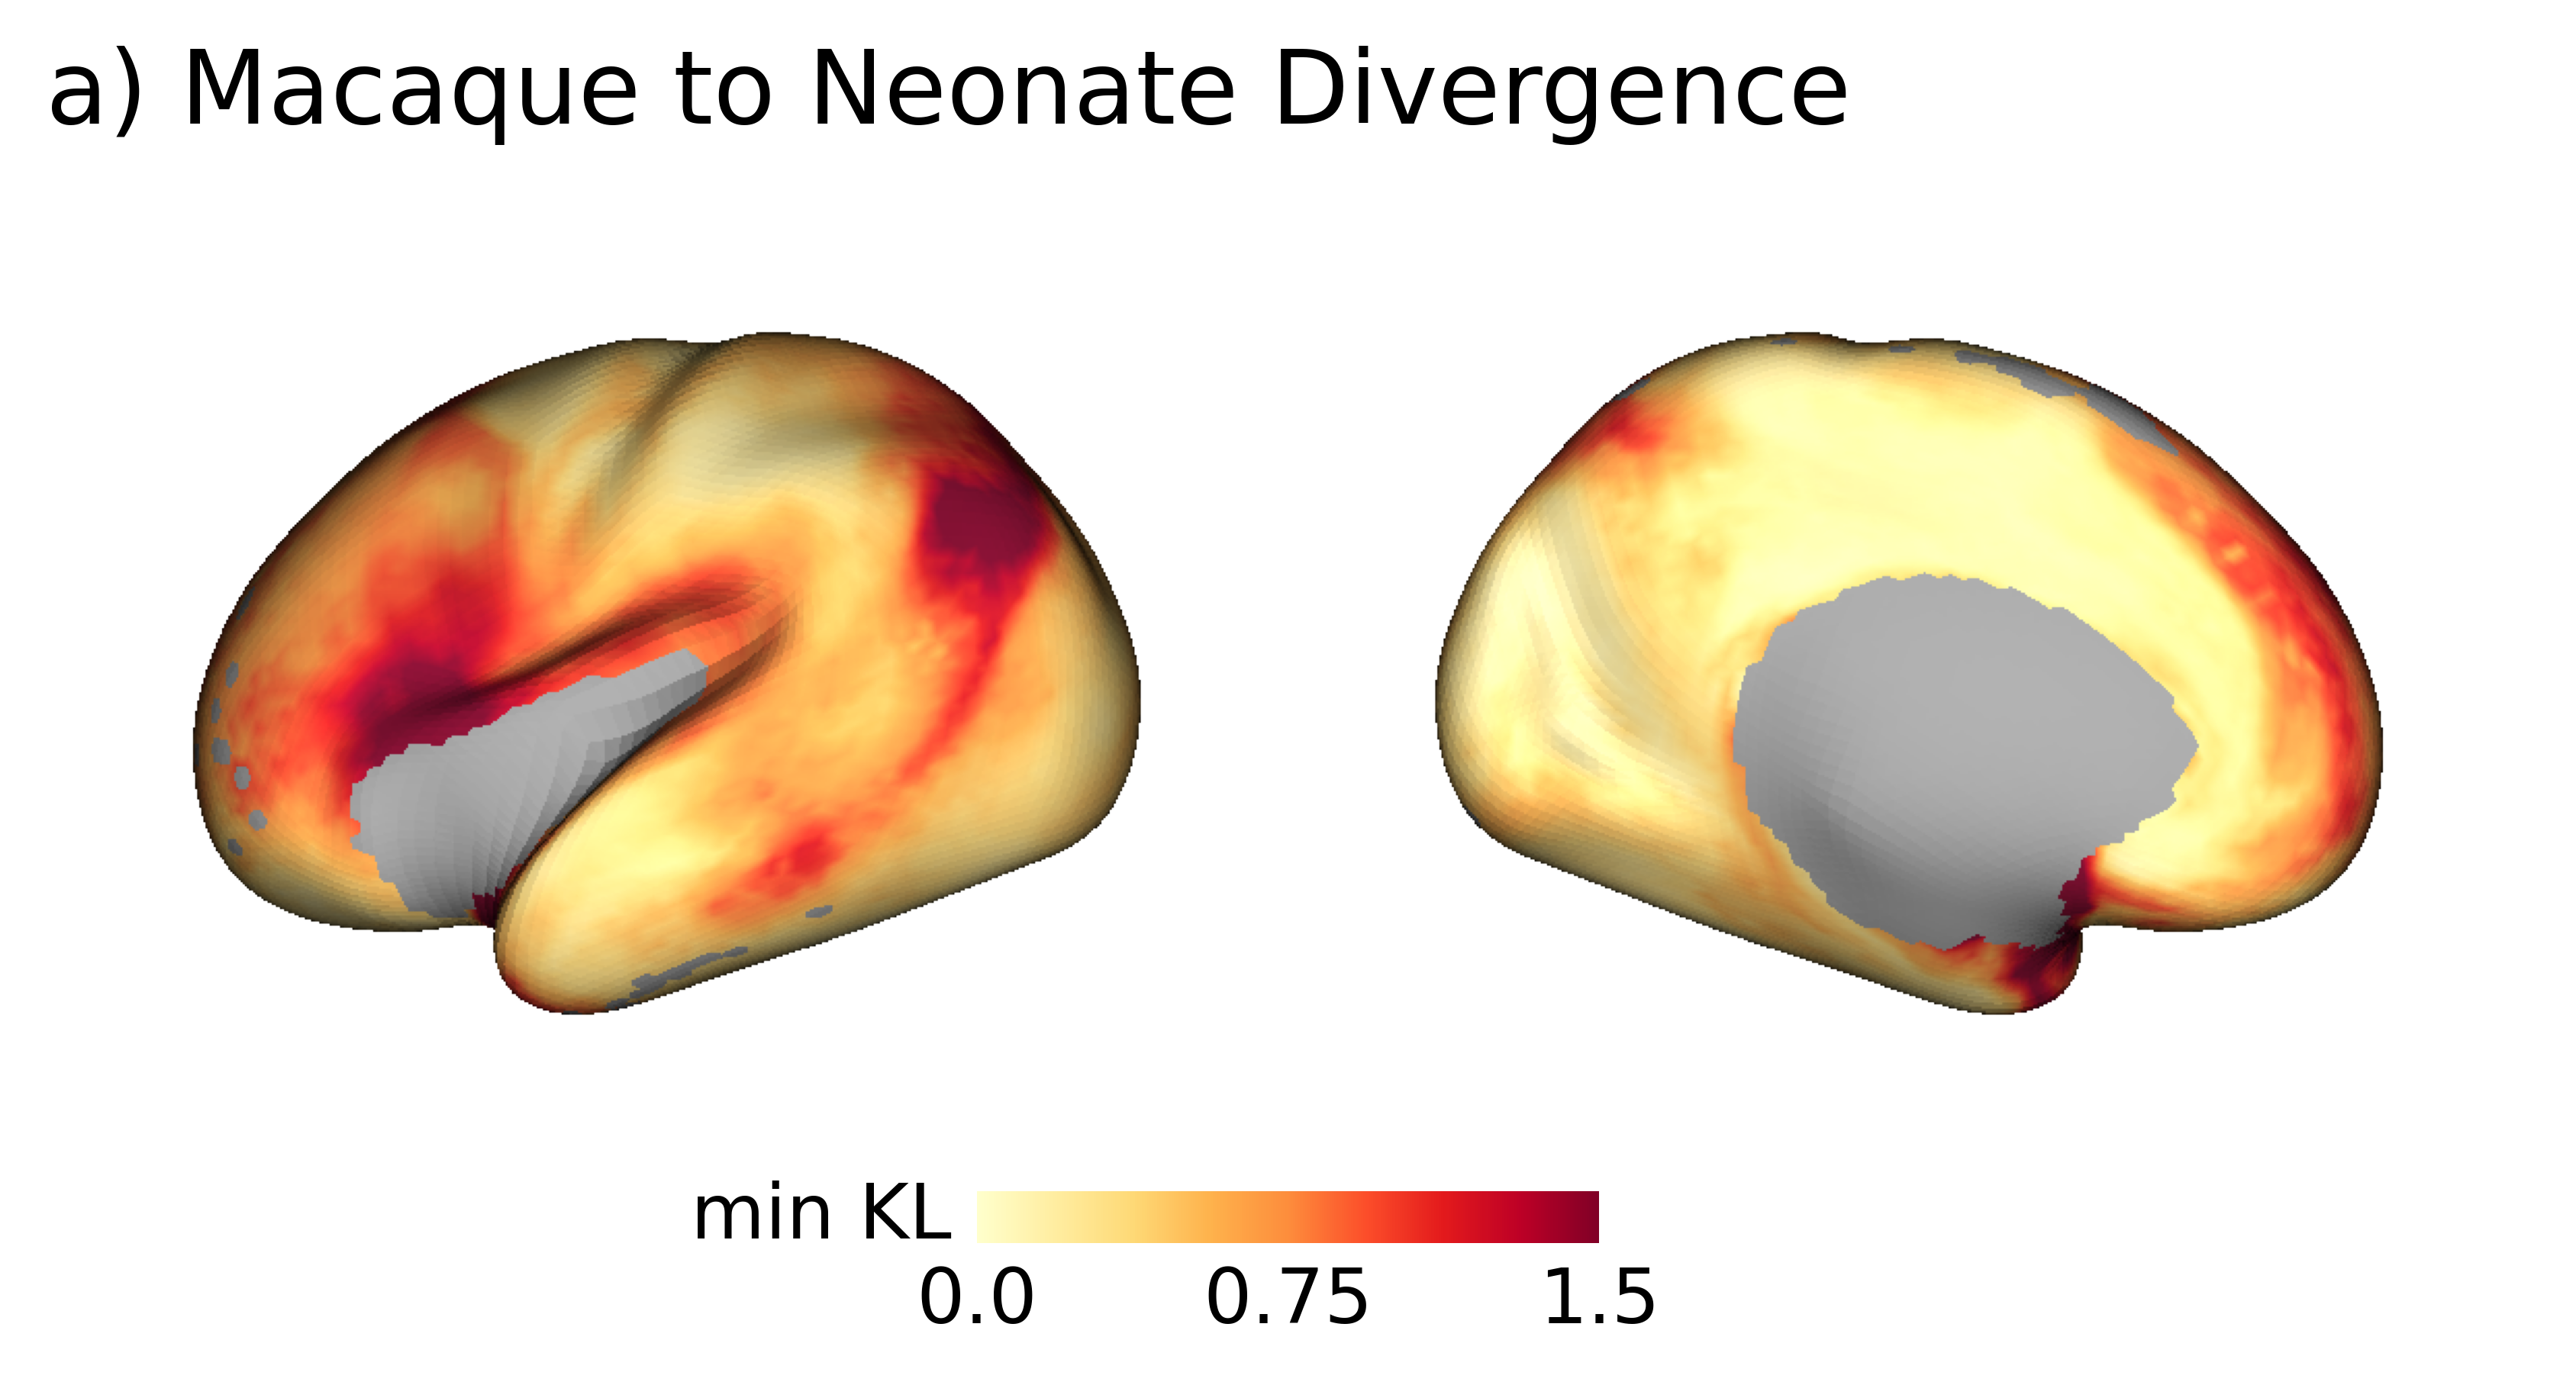

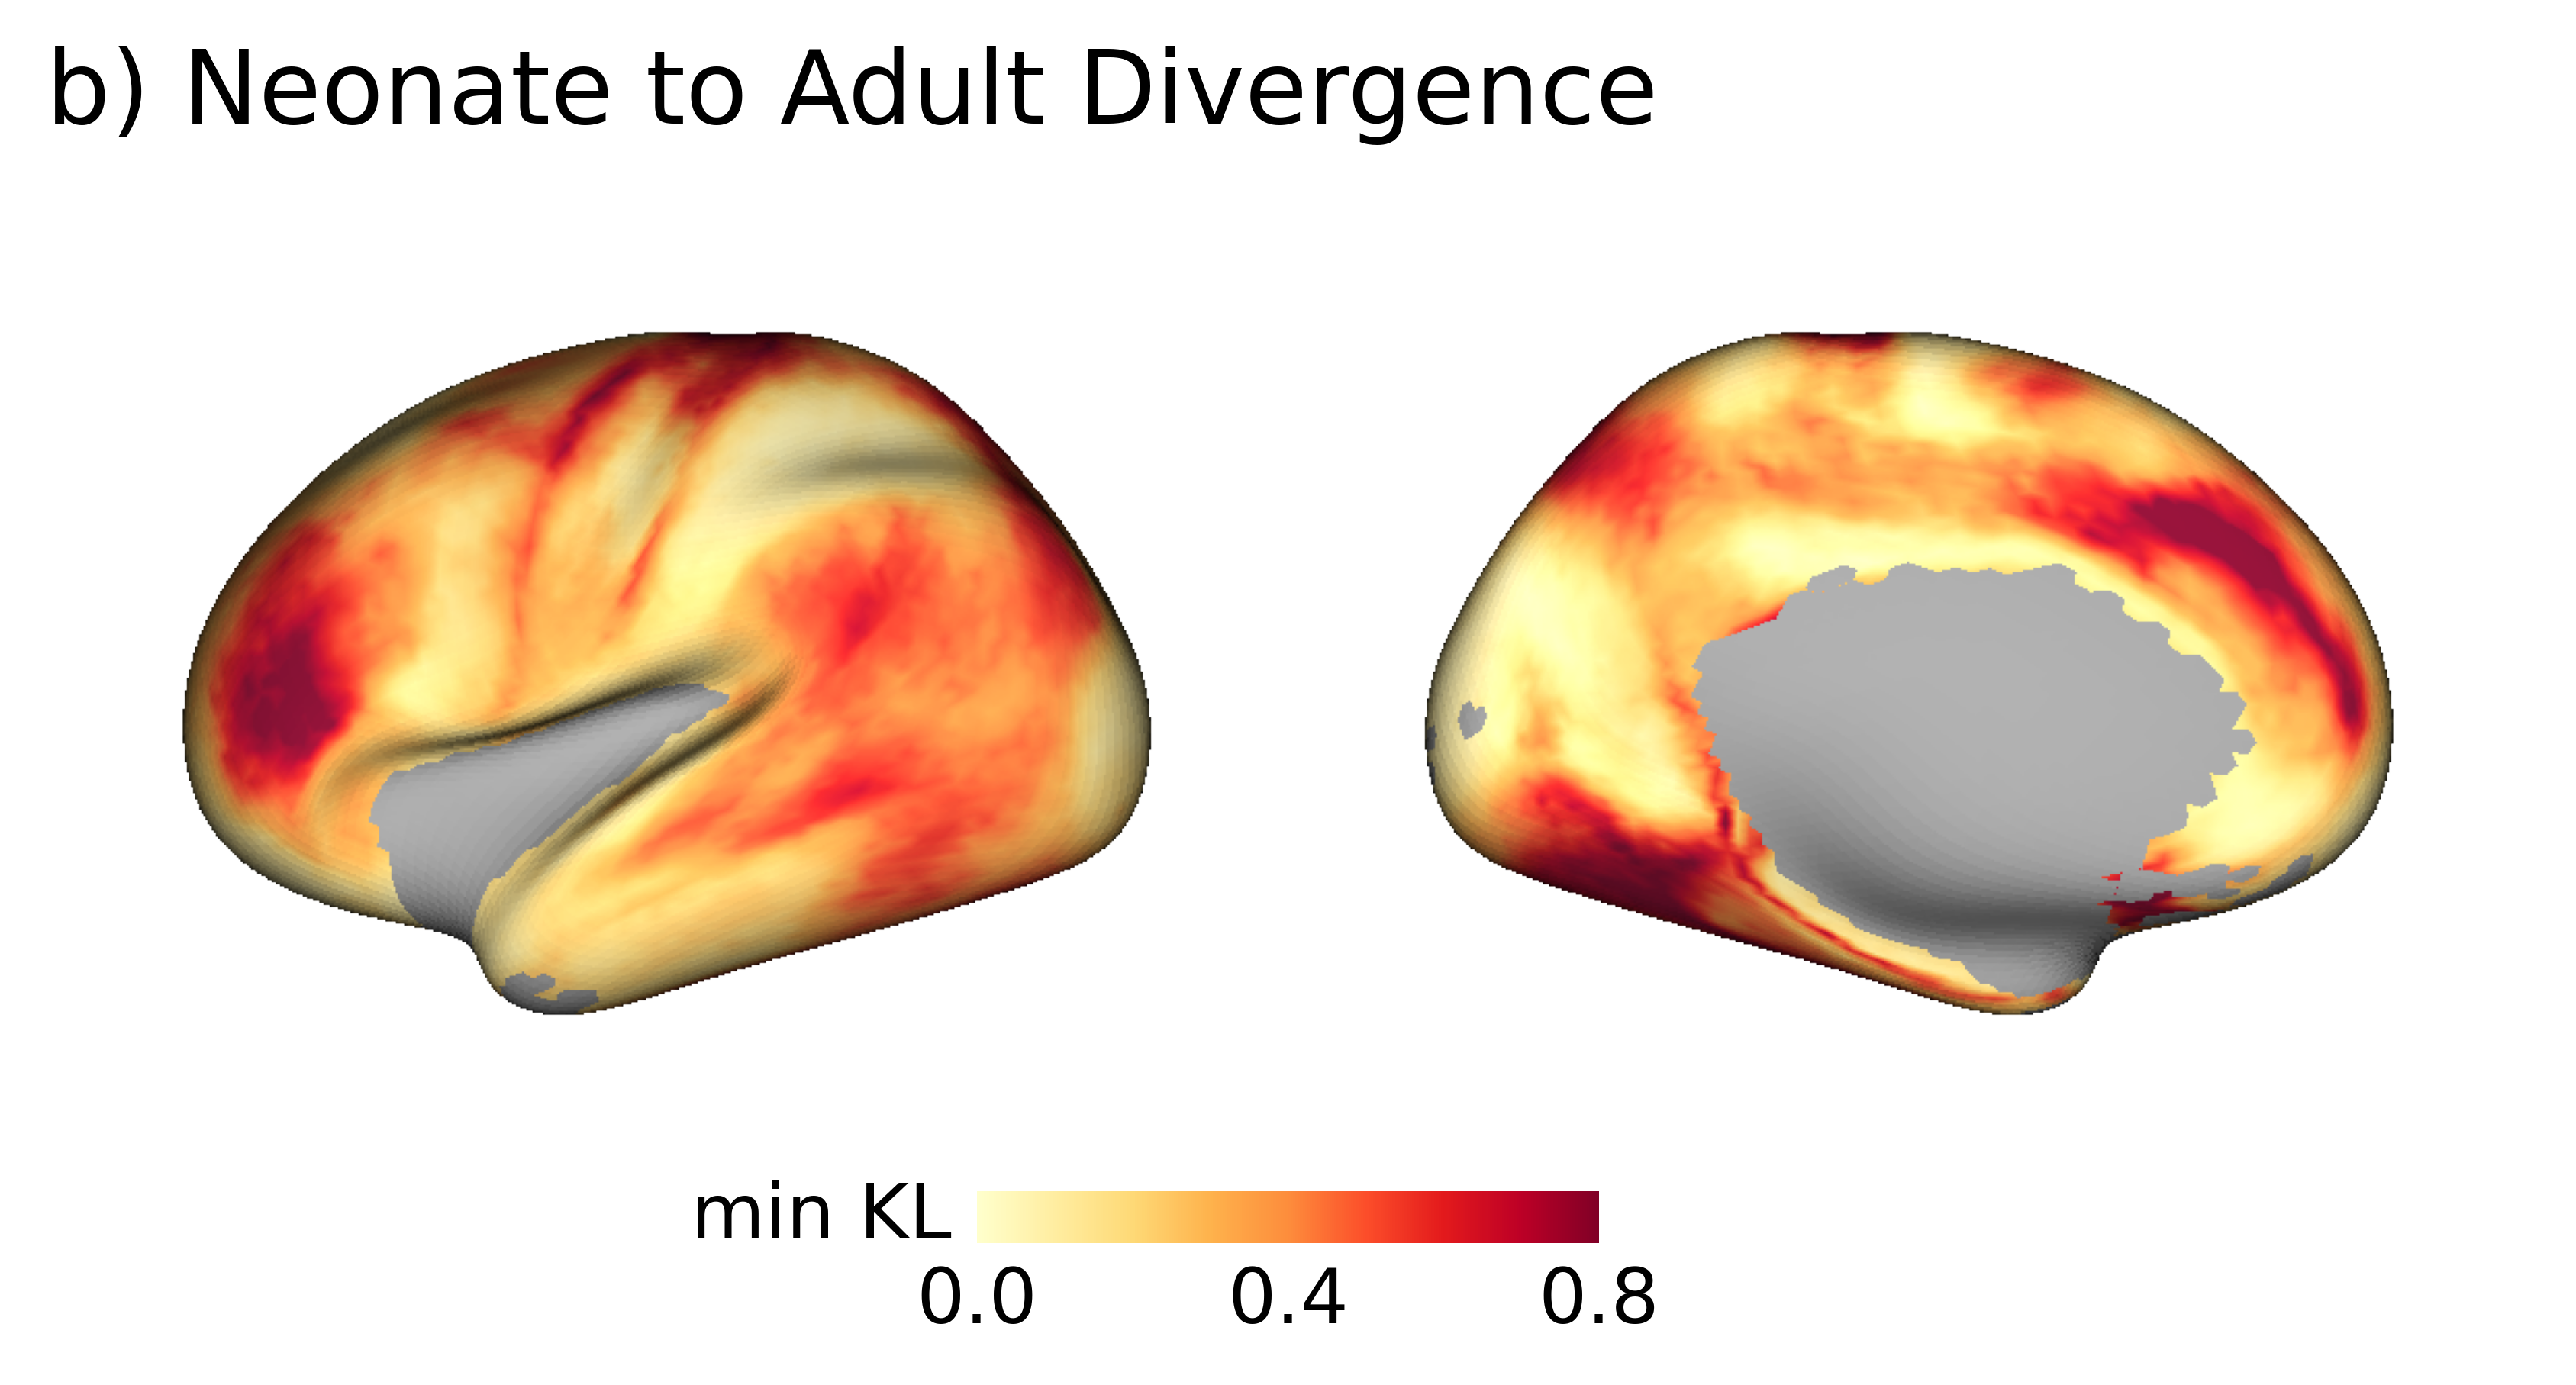

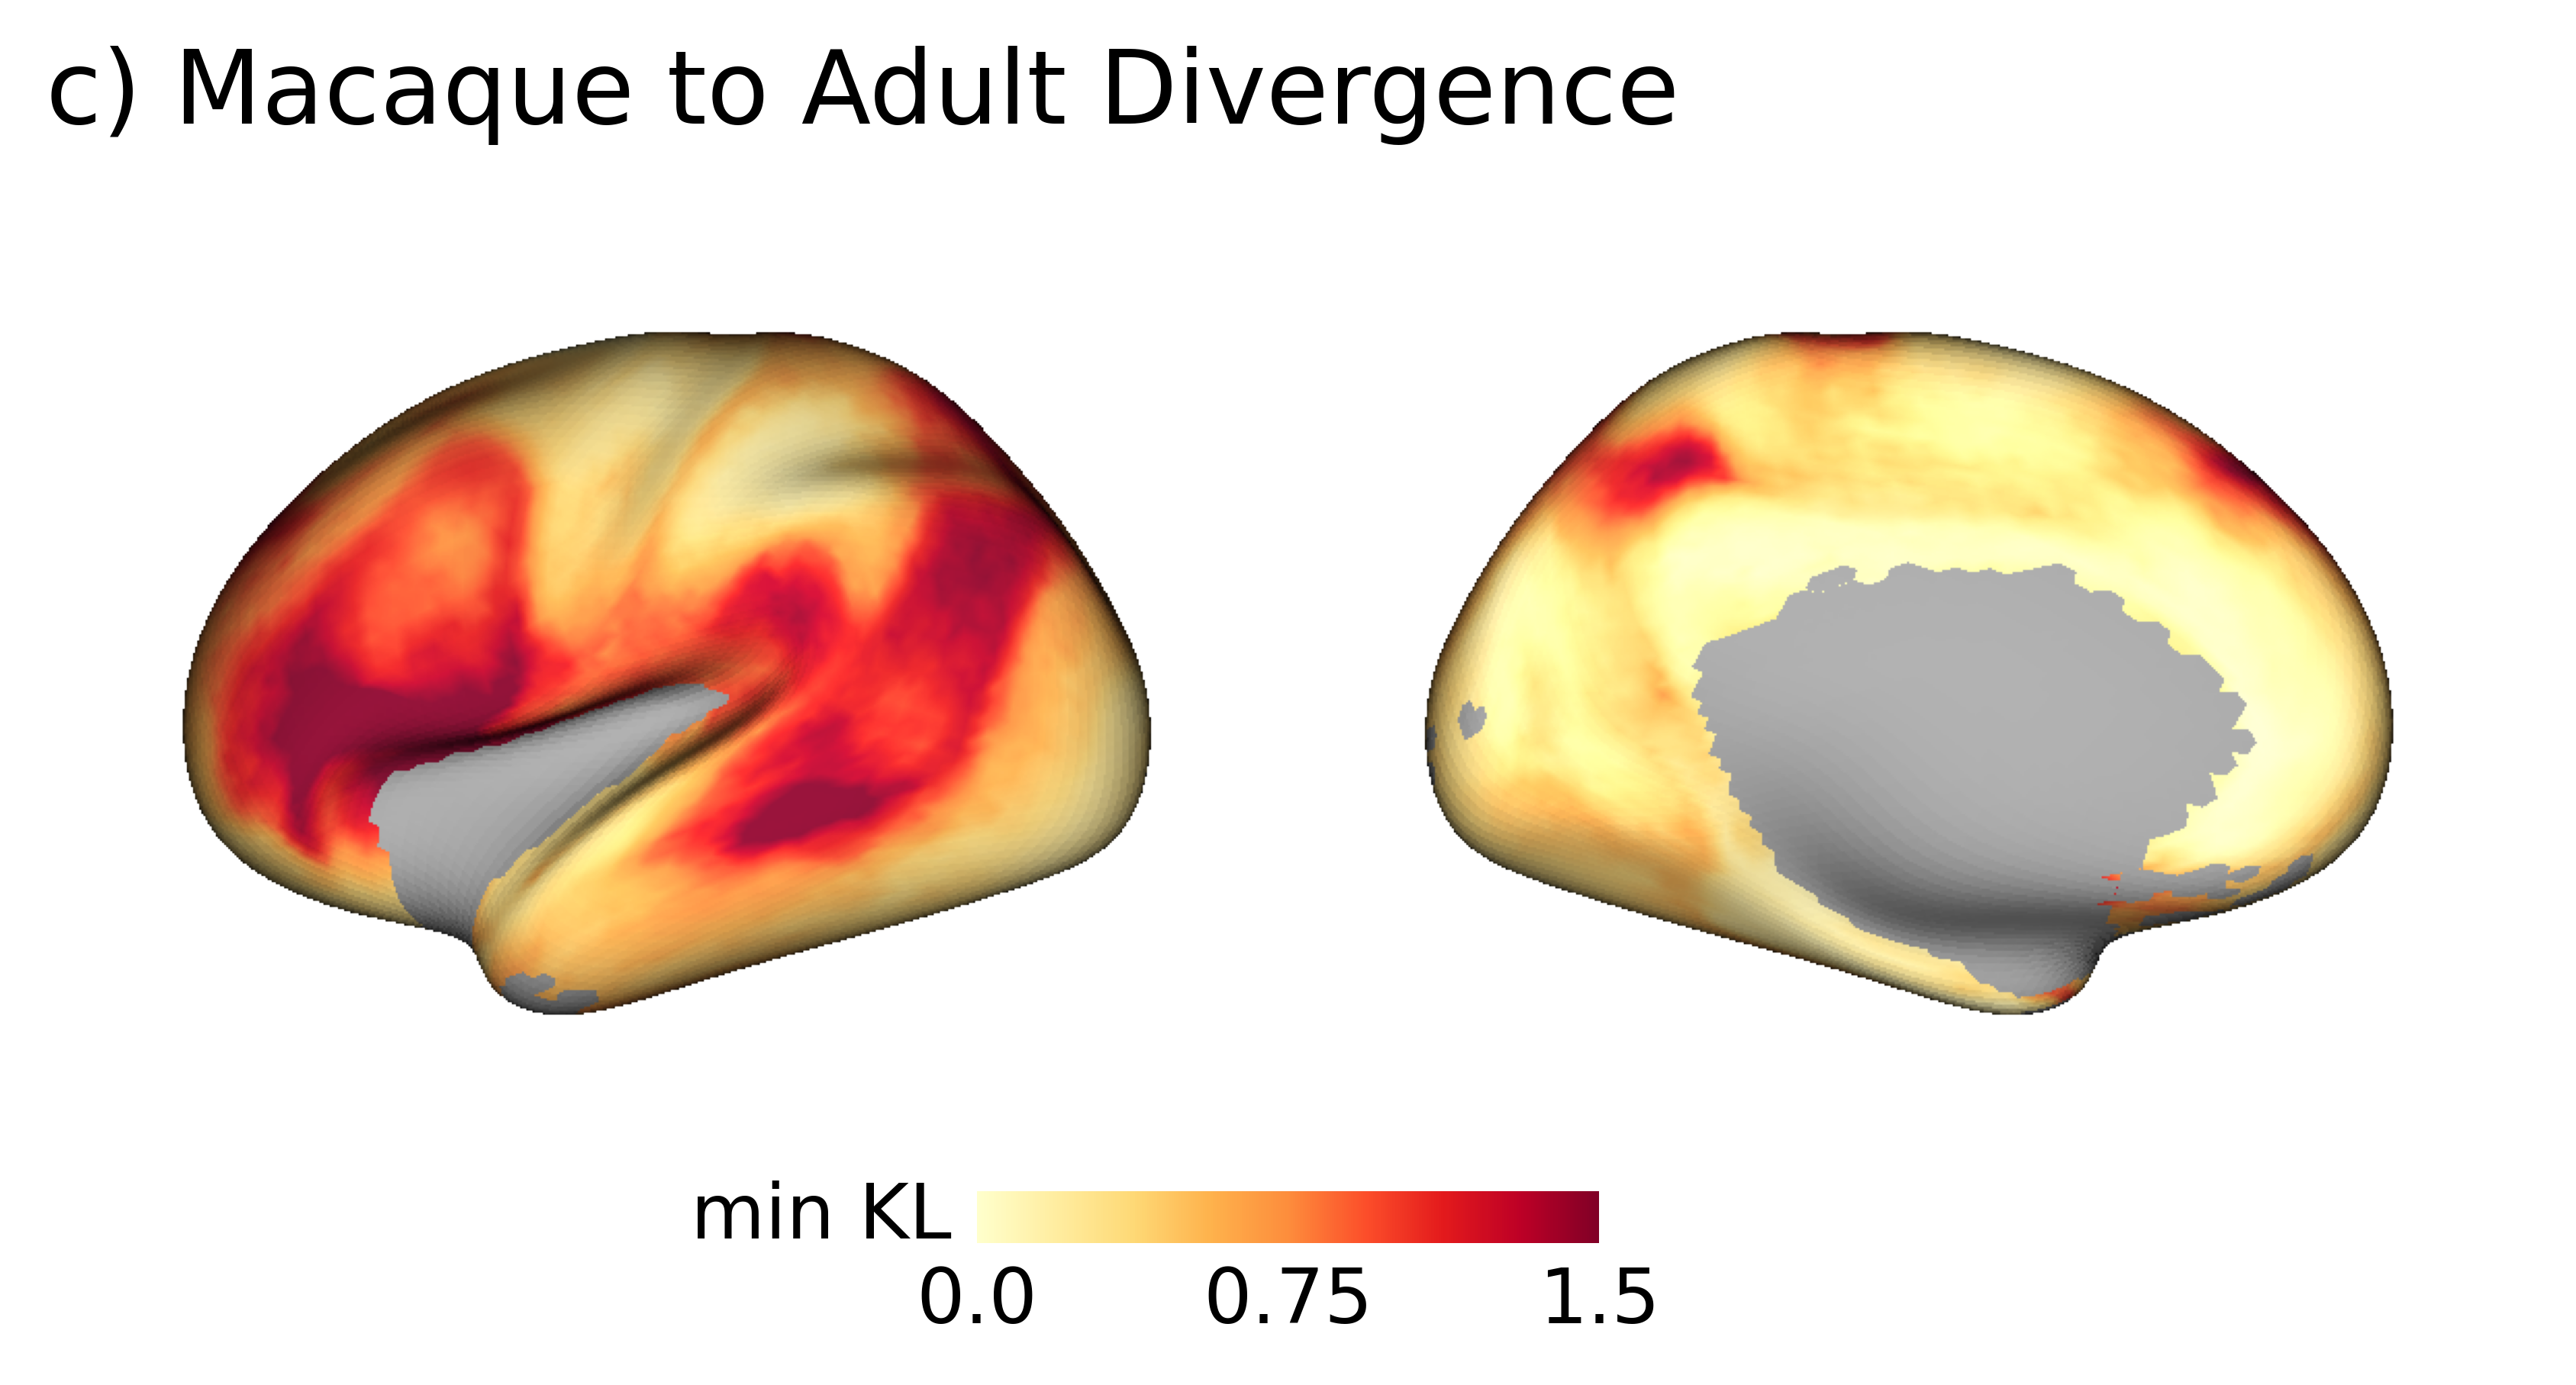

In [17]:
# plot min KL maps
# mac to neonate
plot_surf(f'{results_dir}/ave_grp_dhcpmac_minKLD.dscalar.nii', 
           f'{surf_dir}/L.rneo.very_inflated.resampled.surf.gii', 
           f'{surf_dir}/R.rneo.very_inflated.resampled.surf.gii',
           neo_roi_l, neo_roi_r, 'YlOrRd', [0, 1.5], 'a) Macaque to Neonate Divergence', 
           cbar_title="min KL", zoom=1.5)
    
# neonate to adult
plot_surf(f'{results_dir}/ave_grp_hcpdhcp_minKLD.dscalar.nii', 
           f'{surf_dir}/L.rhum.very_inflated.resampled.surf.gii', 
           f'{surf_dir}/R.rhum.very_inflated.resampled.surf.gii',
           hum_roi_l, hum_roi_r, 'YlOrRd', [0, 0.8], 'b) Neonate to Adult Divergence', 
           cbar_title="min KL", zoom=1.5)
    
# mac to adult
plot_surf(f'{results_dir}/ave_grp_hcpmac_minKLD.dscalar.nii', 
           f'{surf_dir}/L.rhum.very_inflated.resampled.surf.gii', 
           f'{surf_dir}/R.rhum.very_inflated.resampled.surf.gii',
           hum_roi_l, hum_roi_r, 'YlOrRd', [0, 1.5], 'c) Macaque to Adult Divergence', 
           cbar_title="min KL", zoom=1.5)

In [18]:
# plot variance of min KL maps
# mac to neonate
plot_surf(f'{results_dir}/var_grp_dhcpmac_minKLD.dscalar.nii', 
           f'{surf_dir}/L.rneo.very_inflated.resampled.surf.gii', 
           f'{surf_dir}/R.rneo.very_inflated.resampled.surf.gii',
           neo_roi_l, neo_roi_r, 'YlOrRd', [0, 0.15], 'a) Macaque to Neonate', 
           cbar_title="Variance", zoom=1.5)
    
# neonate to adult
plot_surf(f'{results_dir}/var_grp_hcpdhcp_minKLD.dscalar.nii', 
           f'{surf_dir}/L.rhum.very_inflated.resampled.surf.gii', 
           f'{surf_dir}/R.rhum.very_inflated.resampled.surf.gii',
           hum_roi_l, hum_roi_r, 'YlOrRd', [0, 0.03], 'b) Neonate to Adult', 
           cbar_title="Variance", zoom=1.5)
    
# mac to adult
plot_surf(f'{results_dir}/var_grp_hcpmac_minKLD.dscalar.nii', 
           f'{surf_dir}/L.rhum.very_inflated.resampled.surf.gii', 
           f'{surf_dir}/R.rhum.very_inflated.resampled.surf.gii',
           hum_roi_l, hum_roi_r, 'YlOrRd', [0, 0.15], 'c) Macaque to Adult', 
           cbar_title="Variance", zoom=1.5)

## Plots of connectivity patterns across all subjects in group for Fig. 5f
### Loads subject-wise blueprints and retrieves connectivity profiles for vertex indices identified using group-averaged KL maps

### Below cannot be run without individual maps subject to data access agreements

In [6]:
## Get fingerprints for selected vertices
# choose vertex from joint-maps
# BA45: adult = 5973, neonate = 5995, macaque = 3696
# BA44: adult = 6062, neonate = 6058, macaque = 5998

ba45 = pd.DataFrame(columns=['run', 'tract', 'spec', 'conn'])
ba44 = pd.DataFrame(columns=['run', 'tract', 'spec', 'conn'])

tract_names = sorted(list(set([ x.split("_")[0] for x in tracts ])))

for i, sub in tqdm(enumerate(hcplist)):
    hum = loadbp(f"{data_dir}/ind_hcp_blueprints/{sub}.dscalar.nii", 
                 hum_n_left, tracts, hum_mask, hum_parc, fs_mask_out)
    hum = hum[:,:hum_n_left]
    hm = hum_mask[:int(hum_mask.shape[0]/2)]
    # BA45:
    hum_ind = 5408
    temp = pd.DataFrame({'run':i, 'tract':tract_names, 'spec':'hum', 
                     'conn':hum[:,hum_ind].reshape(len(tract_names),)})
    ba45 = ba45.append(temp, ignore_index=True)
    # BA44:
    hum_ind = 5497
    temp = pd.DataFrame({'run':i, 'tract':tract_names, 'spec':'hum', 
                     'conn':hum[:,hum_ind].reshape(len(tract_names),)})
    ba44 = ba44.append(temp, ignore_index=True)
    
    
for i, sub in tqdm(enumerate(neolist)):
    neo = loadbp(f"{data_dir}/ind_dhcp_blueprints/{sub}.dscalar.nii", 
                 neo_n_left, tracts, neo_mask, neo_parc, fs_mask_out)
    neo = neo[:,:neo_n_left]
    nm = neo_mask[:int(neo_mask.shape[0]/2)]
    # BA45:    
    neo_ind = 5351
    temp = pd.DataFrame({'run':i, 'tract':tract_names, 'spec':'neo', 
                     'conn':neo[:,neo_ind].reshape(len(tract_names),)})
    ba45 = ba45.append(temp, ignore_index=True)
    # BA44:
    neo_ind = 5414
    temp = pd.DataFrame({'run':i, 'tract':tract_names, 'spec':'neo', 
                     'conn':neo[:,neo_ind].reshape(len(tract_names),)})
    ba44 = ba44.append(temp, ignore_index=True)    
    
    
for i, sub in tqdm(enumerate(maclist)):  
    macsub = maclist[np.random.randint(0, maclist.shape[0])]
    mac = loadbp(f"{data_dir}/ind_mac_blueprints/{macsub}.dscalar.nii", 
                 mac_n_left, tracts, mac_mask, mac_brod, ba_mask_out, macchk=True)
    mac = mac[:,:mac_n_left]
    mm = mac_mask[:int(mac_mask.shape[0]/2)]

    # BA45:
    mac_ind = 3083
    temp = pd.DataFrame({'run':i, 'tract':tract_names, 'spec':'mac', 
                     'conn':mac[:,mac_ind].reshape(len(tract_names),)})
    ba45 = ba45.append(temp, ignore_index=True)
    # BA44:
    mac_ind = 5385
    temp = pd.DataFrame({'run':i, 'tract':tract_names, 'spec':'mac', 
                     'conn':mac[:,mac_ind].reshape(len(tract_names),)})
    ba44 = ba44.append(temp, ignore_index=True)
    

(0.0, 0.5)

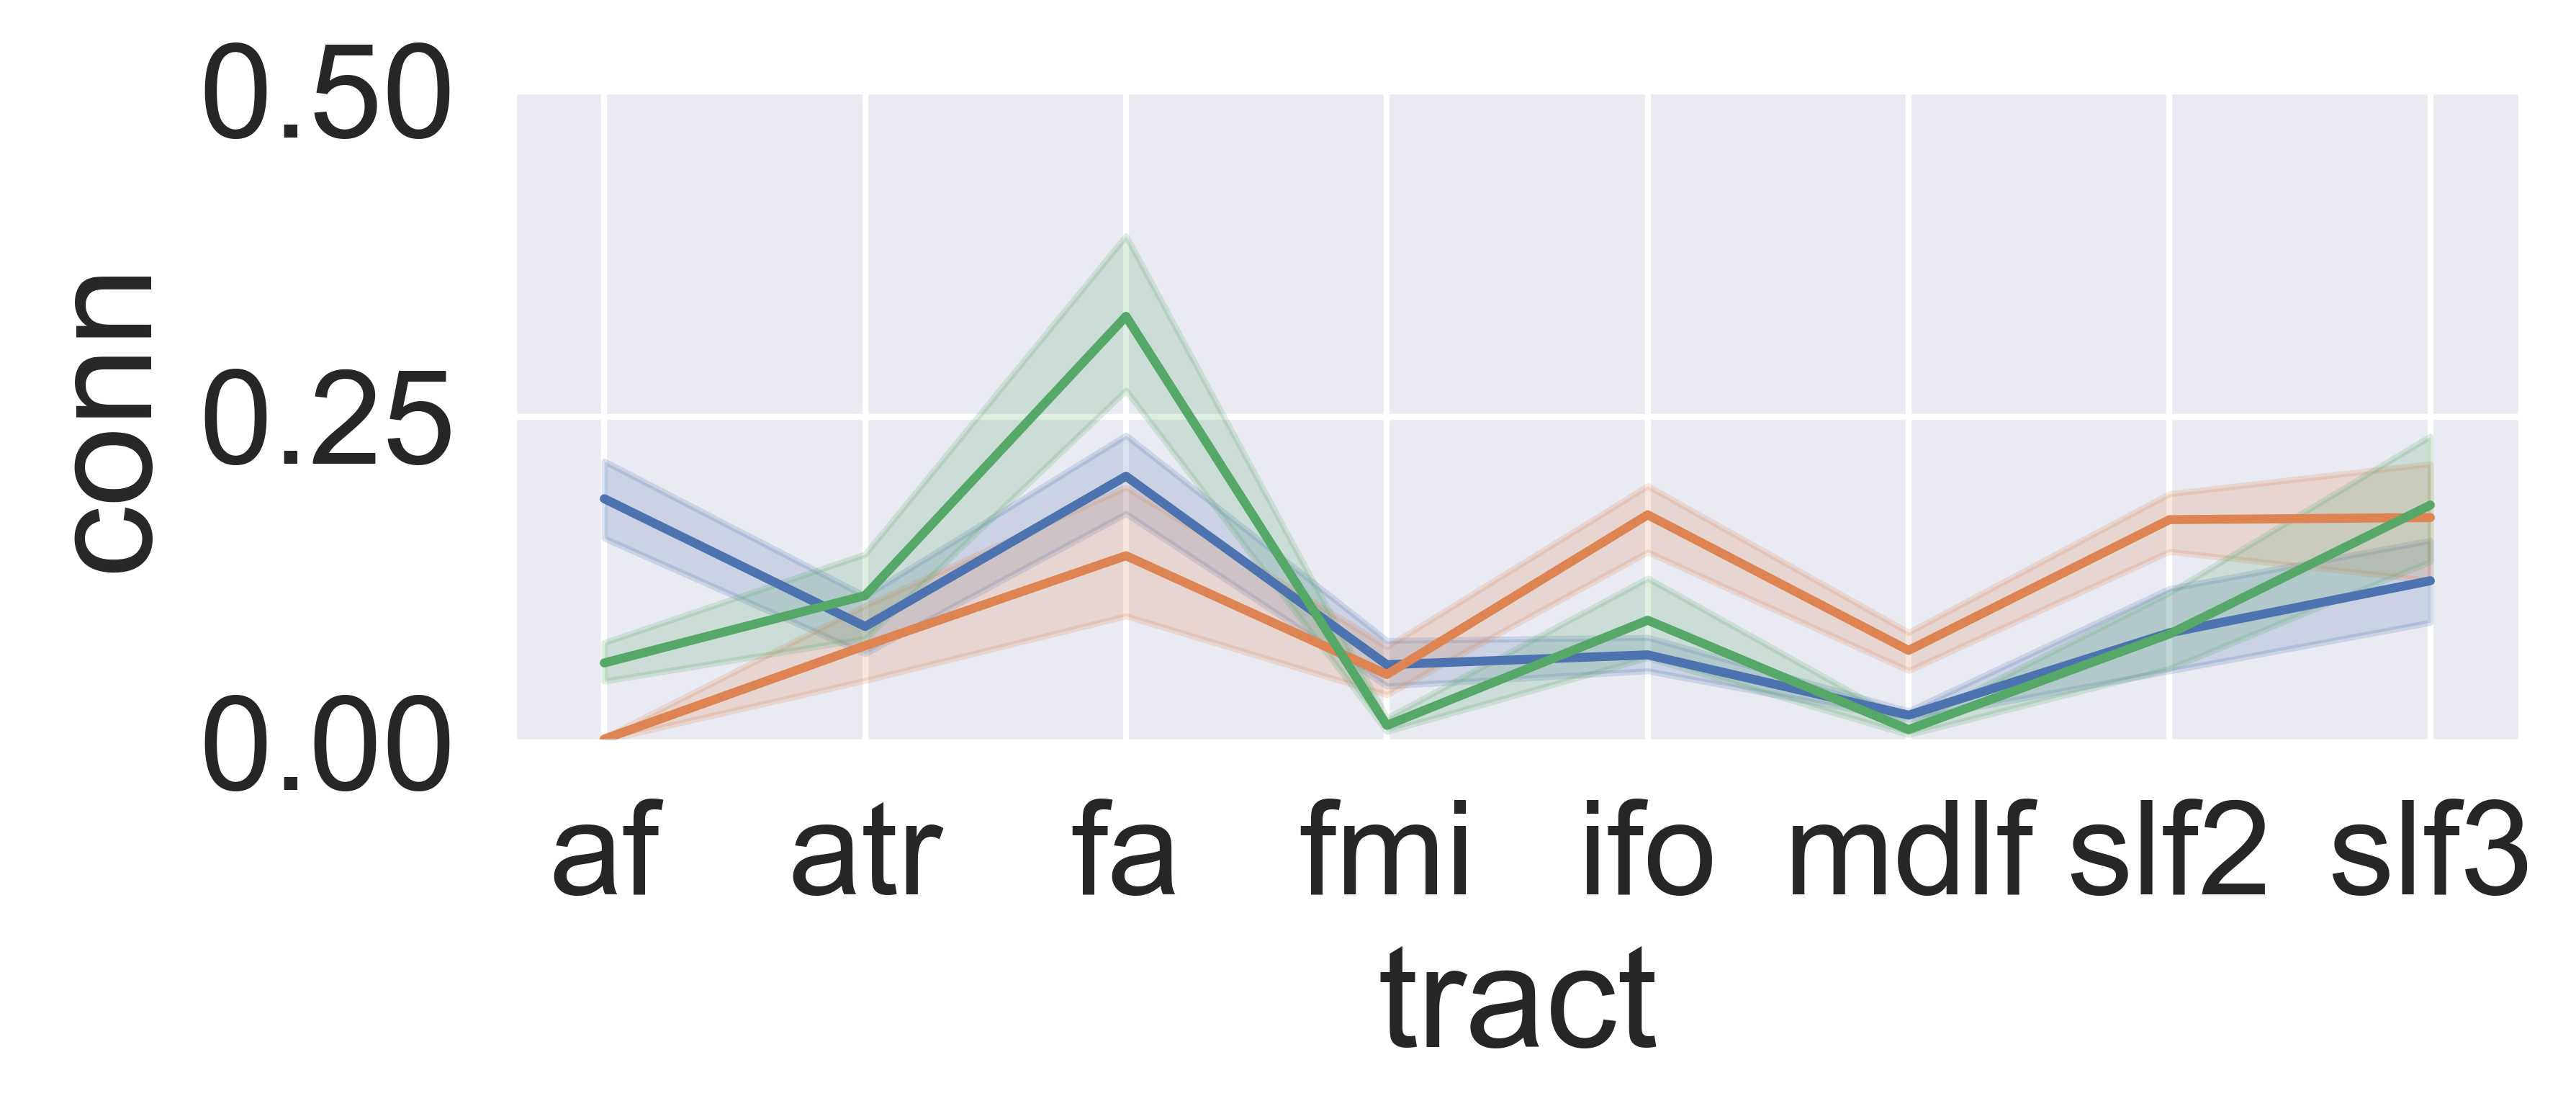

In [11]:
# BA45
tget = ['af', 'atr', 'fa', 'fmi', 'ifo', 'mdlf', 'slf2', 'slf3']

# plot connectivity patterns
sns.set_theme()
sns.set(font_scale=2)
plt.rcParams['figure.dpi'] = 600

fig, ax = plt.subplots(1, 1, figsize=(6, 2))
sns.lineplot(data=ba45[ba45.tract.isin(tget)], y='conn', x='tract', 
             hue='spec', hue_order=['hum', 'mac', 'neo'], legend = False)
plt.ylim([0, 0.5])

(0.0, 0.5)

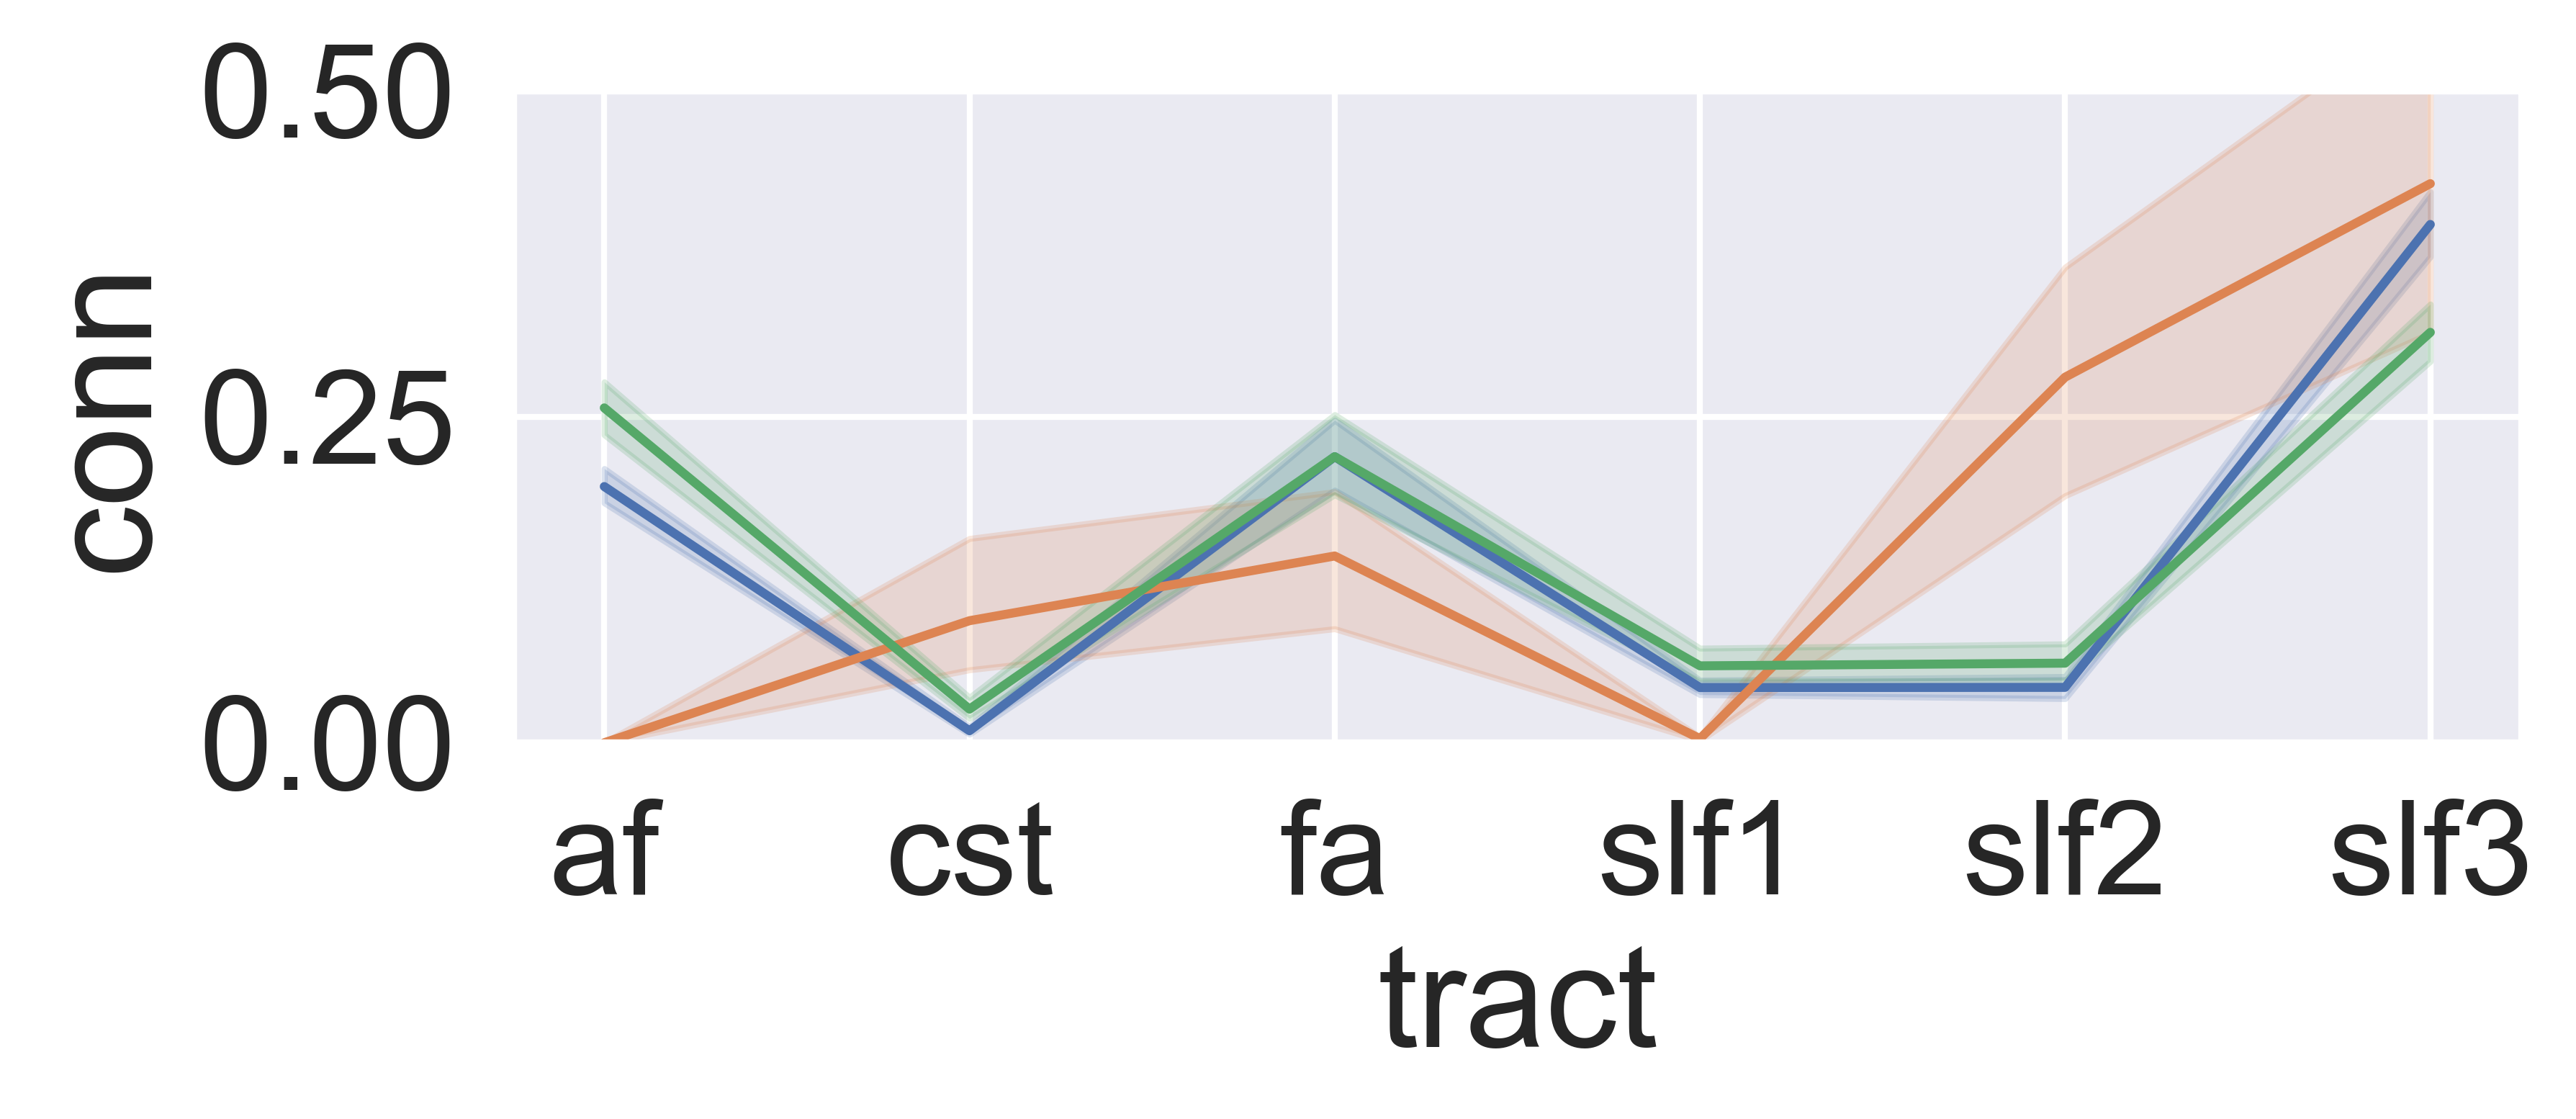

In [12]:
# BA44
tget = ['af', 'cst', 'fa', 'slf1', 'slf2', 'slf3']

# plot connectivity patterns

fig, ax = plt.subplots(1, 1, figsize=(6, 2))
sns.lineplot(data=ba44[ba44.tract.isin(tget)], y='conn', x='tract', 
             hue='spec', hue_order=['hum', 'mac', 'neo'], legend = False)
plt.ylim([0, 0.5])